### ВВодная часть:

Условия -  крупный интернет-магазин. Отделом маркетинга  подготовлен список гипотез для увеличения выручки.

Задача - Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты


Данные — три датасета:
+ "hypothesis.csv"  - характеристики предлагаемых гипотез
+ "orders.csv" - информацию о заказах с разделением по тестируемым группам
+ "visitors.csv" - информацией о посещениях сайта с разделением по тестируемым группам

Предмет исследования - исследование влияния измененений на метрики и определение приоритета  самих изменений

Методы исследования:
+ фреймворк ICE для приоритизации гипотез
+ фреймворк RICE для приоритизации гипотез
+ методы А/В тестирования
+ средства язык PYTHON

План исследования: 
+ Загрузка данных и необходимых библиотек PYTHON
+ Общая настройка среды
+ Изучение входных данных
+ Предобработка входных данных
+ Определение наиболее приоритетных гипотез
+ А/В тест 'сырых' данных
+ Очистка от выбросов
+ А/В тест 'очищенных' данных
+ Подведение итогов - анализ результатов и подготовка рекомендаций

#### Получение данных и импорт инструментов анализа

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import warnings

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)
# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)
# задаем размер графика
sns.set(rc={'figure.figsize':(9,5)})

In [3]:
# чтение файлов с данными
hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    ) 

#### Изучение данных

In [4]:
# обзор датафрейма hypothesis
hypothesis.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Снимок данных
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
# обзор датафрейма orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
# Поиск дублей строк
orders.duplicated().sum()

0

In [8]:
# Снимок данных
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [9]:
#
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [13]:
#
a = orders.loc[orders['group'] == 'A', 'visitor_id'].nunique()
b = orders.loc[orders['group'] == 'B', 'visitor_id'].nunique()
ab = orders['visitor_id'].nunique()
c =round((a + b - ab)*100 / ab, 2)
print("Количество пользователей в группе  А - ", a)
print("Количество пользователей в группе  В - ", b)
print("Количество пользователей попавших в обе группы - ", a + b - ab)
print("% пользователей попавших в обе группы -  ", c )

Количество пользователей в группе  А -  503
Количество пользователей в группе  В -  586
Количество пользователей попавших в обе группы -  58
% пользователей попавших в обе группы -   5.63


In [14]:
# Статистика данных
# orders.describe()

In [15]:
# обзор датафрейма visitors
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [16]:
# Поиск дублей строк
visitors.duplicated().sum()

0

In [17]:
# Снимок данных
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


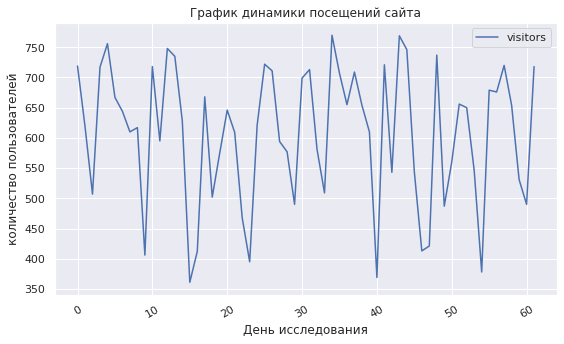

In [18]:
visitors['visitors'].plot()
plt.title('График динамики посещений сайта')
plt.ylabel("количество пользователей")
plt.xlabel('День исследования')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [19]:
visitors['visitors'].max() - visitors['visitors'].min()

409

In [20]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [21]:
# Статистика данных
# visitors.describe()

In [22]:
print(f"начальная дата {visitors['date'].min().date()} \
конечная дата {visitors['date'].max().date()} в данных таблицы visitors" )

print(f"начальная дата {orders['date'].min().date()} \
конечная дата {orders['date'].max().date()} в данных таблицы orders" )

начальная дата 2019-08-01 конечная дата 2019-08-31 в данных таблицы visitors
начальная дата 2019-08-01 конечная дата 2019-08-31 в данных таблицы orders


#####  Вывод. Результат изучения  данных:
+ Пропуски не обнаружены
+ Дубликаты не обнаружены
+ Тип данных в столбцах некорректный, ---  требует иправления
+ Наименования столбцов не соответствует змеиному стилю ---  требует иправления
+ Временной интервал в таблицах совпадает
+ Большой разброс в количестве посещений по дням
+ Часть пользователей попадают в обе группы (58 человек). Что составдяет около 5%  


#### Предобработка данных

In [11]:
# Исправление наименования столбцов 
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

In [12]:
# Исправление типа данных для столбцов с датами
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

##### Вывод: Данные  готовы для анализа

## Часть 1. Приоритизация гипотез.

Задача
+ Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
+ Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
+ Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

##### ICE (от. англ.: Impact, Confidence, Effort/ Влияние, Уверенность, Усилия).

In [23]:
hypothesis['ice'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


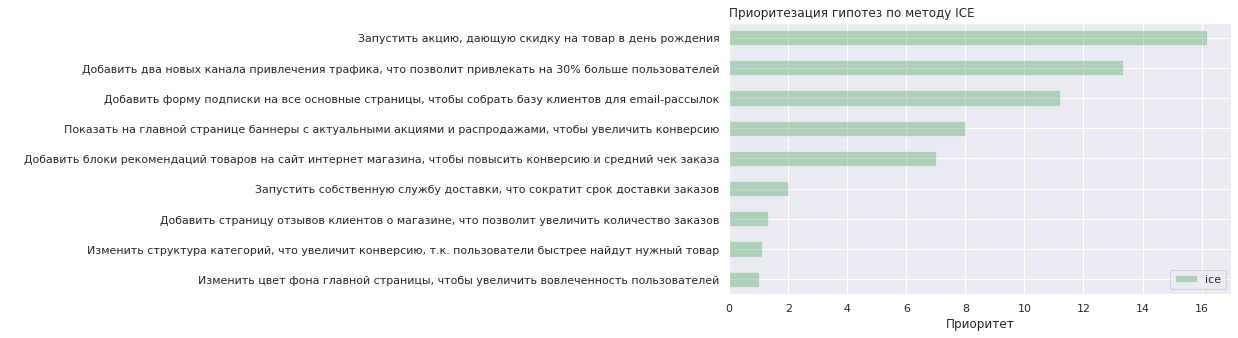

In [24]:
grafic = (hypothesis[['hypothesis', 'ice']]
      .set_index('hypothesis')
      .sort_values('ice', ascending=True)
      .plot(kind='barh', color='g', alpha=0.4)
     )
grafic.grid(True)
grafic.set_xlabel('Приоритет')
grafic.set_ylabel(' ')
grafic.set_title('Приоритезация гипотез по методу ICE', loc='left')
plt.show()

В результате анализа по фреймворку ICE  явно выделяются 5 гипотез

##### Фреймворк RICE.
Добавим к расчету параметр Reach (англ.: Охват)

In [25]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


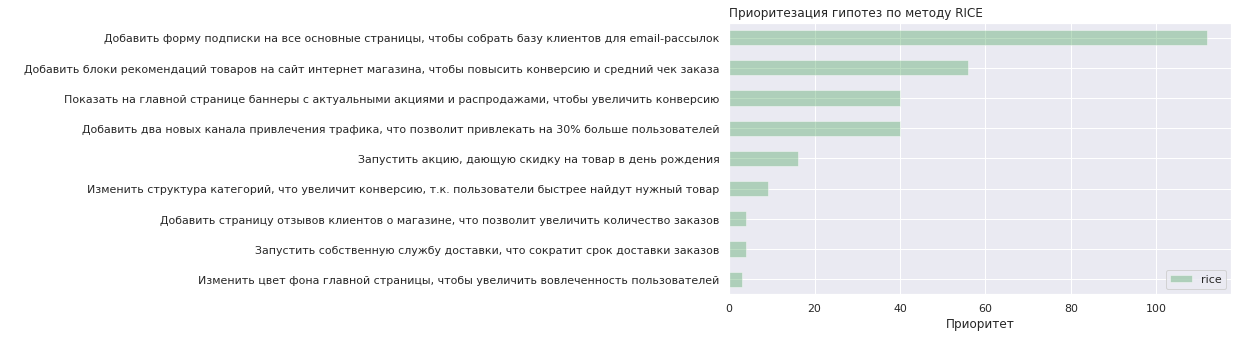

In [26]:

grafic = (hypothesis[['hypothesis', 'rice']]
      .set_index('hypothesis')
      .sort_values('rice', ascending=True)
      .plot(kind='barh', color='g', alpha=0.4)
     )
grafic.grid(True)
grafic.set_xlabel('Приоритет')
grafic.set_ylabel(' ')
grafic.set_title('Приоритезация гипотез по методу RICE', loc='left')
plt.show()

Те же гипотезы, но в другой последовательности

In [27]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head()

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2


##### Вывод: 
+ Пять гипотез остаюся лидерами при обоих методах расчета. 
+ Разница  в рангах связана с тем, что один метод учитывает кол-во пользователей, которых затронут изменения, а другой - нет.

Приоритизации гипотез:
+ "Запустить акцию, дающую скидку на товар в день рождения",
+ "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",
+ "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";

При необходимости включения параметра "охват пользователей":
+ "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
+ "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
+ "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"

В итоге наиболее правильным считаю выбрать гипотезу - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

## Часть. Анализ A/B-теста

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Создание агрегированного датафрейма по группам (А или В), для построеня графиков кумулятивной выручки по группам.

In [28]:
# создаем массив уникальных пар  дат и групп A/B
dates_grouped = orders[['date', 'group']].drop_duplicates()

In [29]:
# Агрегированные кумулятивные  данные о заказах по дням
orders_grouped = (dates_grouped.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
        .agg({  'date': 'max', 
              'group': 'max',
              'transaction_id': 'nunique',
              'visitor_id': 'nunique',
              'revenue': 'sum'}),
            axis=1)
        .sort_values(by=['date', 'group']))
orders_grouped

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [30]:
# Агрегированные кумулятивные данные о посетителях интернет-магазина по дням

visitors_grouped = (dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group'] )]
         .agg({'date': 'max', 
               'group': 'max', 
               'visitors': 'sum'}),
            axis=1)
        .sort_values(by=['date', 'group']))

visitors_grouped

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [31]:
# Таблица объединенных кумулятивных данных.

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [32]:
# Дополнительный столбец - конверсия
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,0.033657
58,2019-08-30,A,545,493,4022970,18037,0.030216
59,2019-08-30,B,620,567,5774631,18198,0.034070
60,2019-08-31,A,557,503,4084803,18736,0.029729


In [33]:
cumulative_data['date'].min(), cumulative_data['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-31 00:00:00'))

Временной период совпадает

In [34]:
# Таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [35]:
# Таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

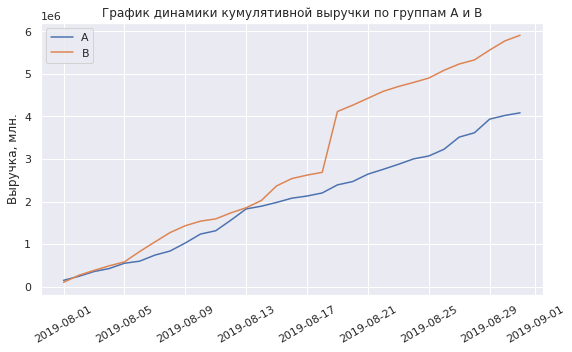

In [36]:
# Построение графиков
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

##### Вывод:
+ Кумулятивная выручка группы А растет линейно
+ Кумулятивная выручка группы В имемеет резкий скачок, это может быть связано с увеличением заказов, либо с появлением анамально очень дорогих заказов в выборке(выбросы)
+ В целом графики близки, если не учитывать скачок 18 августа, оказавший сильное влияние.
+ Необходимо дополнительное исследование данных

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

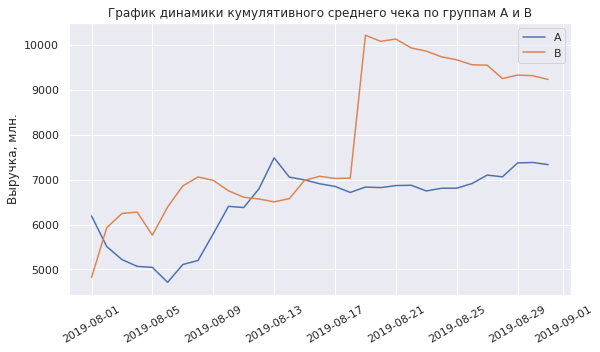

In [37]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

##### Вывод:
+ Средний кумулятивный чек в группе А во второй половине периода стабилизировался
+ Средний кумулятивный чек в группе В сделал резкий скачок, а затем начал снижение. Что можно идентифицировать как выброс (случайный элемент в данных)

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

График относительного изменения кумулятивного среднего чека группы B к группе A.

In [38]:
# Создание таблицы данных
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b'])

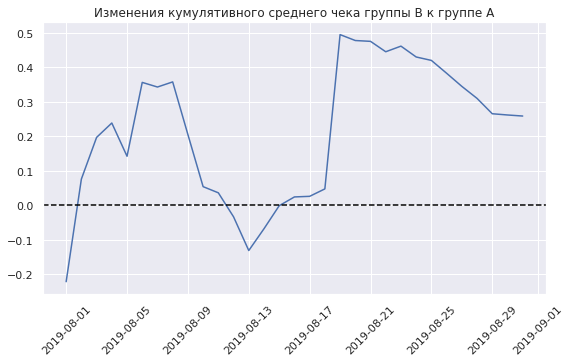

In [39]:
# График отношения средних чеков
plt.plot(cumulative_revenue_ab['date'], 
         (cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b'])/
         (cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45)
plt.show()

##### Вывод:
+ График в нескольких точках резко скачет
+ Это говорит о присутвии не типичных элементов(Или  существующие выбросы или технический сбой при подготовке данных)
+ Несмотря на то что график показывает преимущество группы В, вывод делать еще рано, возможно это икажение выбросами

### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

Подготовка данных

In [40]:
# Данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

In [41]:
# Данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

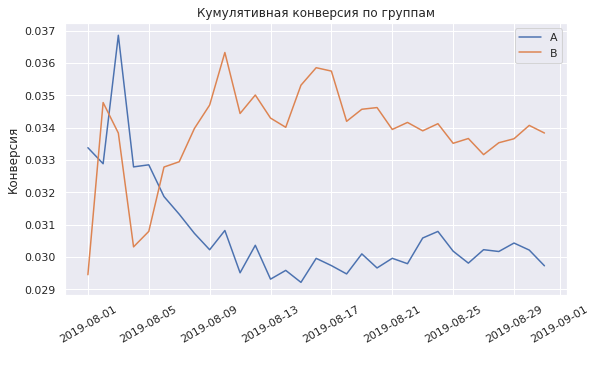

In [42]:
# График кумулятивного среднего количества заказов на посетителя по группам.
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xlabel(' ')
plt.ylabel('Конверсия')
plt.xticks(rotation=30)
plt.show()

##### Вывод:
+ В начале периода были сильные колебания
+ Далее графики стабилизировались
+ Данные по группе В выглядят привлекательнее

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения

Подготовка данных

In [43]:
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']))

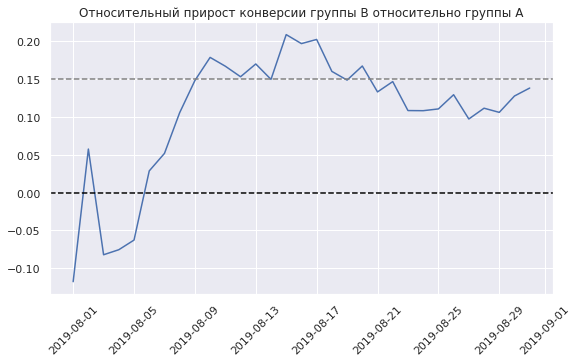

In [44]:
# График относительного изменения кумулятивного среднего количества 
# заказов на посетителя группы B к группе A
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xticks(rotation=45)
plt.show()

##### Вывод:
+ В начале периода группа В проигрывала группе А
+ Затем резкий взлет
+ Затем снова спуск
+ Поведение этого грфика коррелирует с данными получеными ране по другим метрикам (предположение о выбросе)
+ Данные необходимо проанализировать еще раз после чистки от выбросов 

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Пользователи, совершившие много заказов влияют на числитель формулы конверсии (отношение количества заказов к количеству поситителей интернет-магазина за время теста).
"Обычный" пользователь редко совершает более одного-двух заказов в короткий срок (если только речь не идет о сайтах с регулярным спросом (например, продуктовый интернет-магазин)). Посмотрим, что с количеством заказов происходит с участниками нашего тестирования.

In [45]:
# Проверка описательных статистик
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'}))
orders_by_users.columns =  ['visitor_id', 'orders']
orders_by_users['orders'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

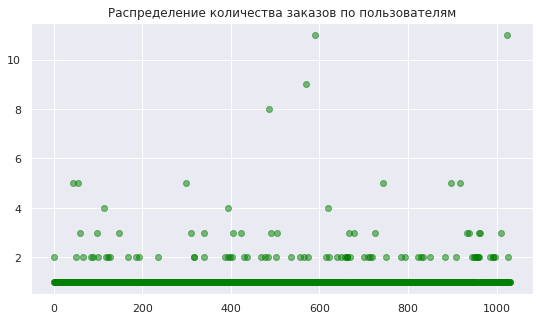

In [46]:
# Точечный график количества заказов по пользователям
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'], color='green', alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.show()

##### Вывод:
+ Большинство пользователей оформляли заказ один раз
+ Много пользователей с 2-3 заказами.
+ Есть те, кто успел сделать за месяц одиннадцать заказов
+ Необходимо посчитать долю клиентов по кол-ву заказов, чтобы определить границу выбросов

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [47]:

np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

##### Вывод:
+ Не более 5% пользователей совершали больше 2-х покупок в течение тестирования.
+ Только 1% - четыре и более.
+ Выберем границу для определения аномальных пользователей 4 заказа

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

In [48]:
# Проверка описательных статистик
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

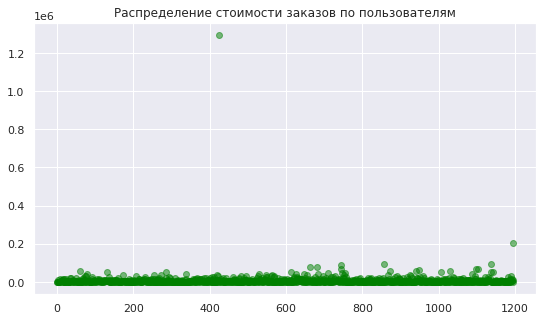

In [49]:
# Точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

##### Вывод: 
Вот тот не типичный заказ , который вызвал всплеск на графиках кумулятивных метрик, а так же другие весомые заказы, которые могут повлиять на результат исследований.

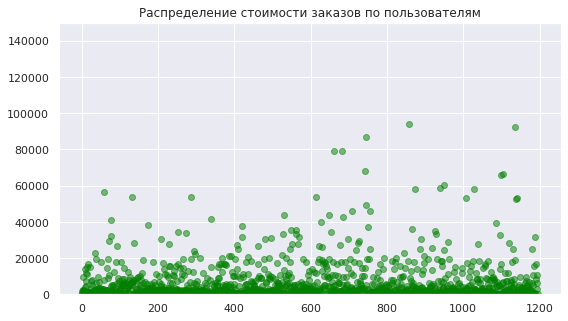

In [50]:
# Точечнуая диаграмма без двух крупных выбросов
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

##### Вывод: 
+ Основная масса заказов не привышает 20000.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [51]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


##### Вывод: 
Определяем границу по величине 99% перцентиля (58233)

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения

Определим основную и альтернативные гипотезы:
+ Н0 : различий в конверси имежду группами нет
+ Н1 : различия в конверси имежду группами есть

Уровень значимости: alpha = 0.05

Так как данные о продажах и средних чеках редко бывают нормально распределены, для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.

In [52]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


df = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)
df.head()

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


В переменных orders_by_users_a и orders_by_users_a для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [53]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Объявим переменные sample_a и sample_b количество заказов для пользователей из разных групп.
Тем кто ничего не заказал, будут соответствовать нули.

In [54]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series( 0, index=np.arange(df['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(df['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0)

Решение с помощью критерия Манна-Уитни :

In [55]:
# Функция для проверки гипотезы о равенстве групп  A и  B
def stat_significance(a, b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(a, b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(b.mean() / a.mean()-1))

In [56]:
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


##### Вывод:
+ По неочищенным данным различия в конверсии между группами есть
+ P-value = 0.017 меньше 0.05. Значит, 

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Определим основную и альтернативные гипотезы:
+ Н0 : Различий в среднем чеке между группами нет
+ Н1 : Различия в среднем чеке между группами есть    

Уровень значимости: alpha = 0.05

Передадим критерию mannwhitneyu() данные о выручке с заказов

In [57]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


##### Вывод:
+ P-value значительно больше 0.05.
+ Отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет оснований

### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

Определение границ анамальных значений (по ранее произведеным рассчетам) :
+ Аномальные пользователи тех, кто совершил от 5 заказов или совершил заказ дороже 58233.
+ Это не более 1 % пользователей
+ Скоректируем  users_with_many_orders (кол-во заказов)
+ Скоректируем users_with_expensive_orders (сумма заказа)
+ Кол-во всего аномальных пользователей рассчитаем методом shape()

In [58]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)

In [59]:
users_with_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id']],
    axis=0,)

users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values())
abnormal_users.shape[0]

15

In [60]:
abnormal_users.head(5)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

Всего 15 аномальных пользователей.

Статистическая значимость различий в конверсии между группами теста по очищенным данным.

Выборки количества заказов по пользователям по группам теста:

In [61]:
sample_a_filtered = pd.concat(
    [ orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'],
        pd.Series( 0, 
                  index=np.arange(df['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders')], axis=0)

sample_b_filtered = pd.concat([
        orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(0, index=np.arange(
                df['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
            name='orders')], axis=0)

In [62]:
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.331%


##### Вывод:
+ На очищенных данных разница в конверсии между группами есть
+ Относительный прирост конверсии группы В отнистельно группы А увеличился на 15.3%

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [63]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


##### Вывод:
+ P-value значительно больше 0.05. 
+ Причин отвергать нулевую гипотезу нет.
+ В среднем чеке групп различий практически нет.

###  Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

+ По конверсии между группами как по «сырым», так и по данным после фильтрации аномалий получено статистически значимое различие

+ По среднему чеку между группами по «сырым» и по данным после фильтрации, аномалий нет статистически значимого различия
+ Средний чек группы В выше (на "очищенных" данных - на ~2%)

+ График относительного изменения кумулятивной конверсии группы B к группе A показывает, что результаты группы В стабильно лучше группы А

#### Общий вывод:


+ Рекомендуем остановить тест
+ Определяем победу группы B (по метрике конверсия результат значимо лучше, чем у группы А).